In [4]:
import numpy as np

from IPython.display import display
from PIL import Image
from peewee import IntegerField, Model, CharField, SqliteDatabase, AutoField
import matplotlib.pyplot as plt

db = SqliteDatabase('events-testing-after-fix.db')


class Events(Model):
    id = AutoField()
    time = IntegerField()
    agent = CharField()
    event = CharField()
    participant_id = IntegerField()
    old_value = CharField(null=True)
    new_value = CharField(null=True)
    screenshot_file = CharField(null=True)

    class Meta:
        database = db

def show_screenshot_for_record(_id):
    events = Events.select().where(Events.id == _id).order_by(Events.time.asc()).limit(1)
    if len(events) == 0:
        print("No events found for id: ", _id)
        return
    event = events[0]
    image_path = event.screenshot_file
    print(_id)
    display(Image.open(image_path))


11 1702482205238 USER OPEN_BOOK 998 None Under the Tuscan Sun -  screenshots/564dc12f-ffad-4319-bfdb-7ef002d4cf8d.png
12 1702482207133 USER NEXT_PAGE 998 None None screenshots/8ce38125-53f1-403a-90d2-9310ba4befc2.png
13 1702482209246 USER SET_TYPOGRAPHY_FONTWEIGHT 998 100 400 screenshots/128001cc-c034-4c29-9caa-506920f1b7af.png
14 1702482210318 USER SET_TYPOGRAPHY_FONTSIZE 998 14 18 screenshots/20e5d766-8ad6-4049-a0fb-c0a2685c6b4b.png
15 1702482211334 USER SET_TYPOGRAPHY_FONTSIZE 998 18 24 screenshots/e03bfc25-500c-4205-9818-6fe8c9df509a.png
16 1702482212789 USER SET_TYPOGRAPHY_FONTSIZE 998 24 18 screenshots/3dee6779-f4f1-4772-9a17-a82013a2048d.png
17 1702482214902 USER SET_THEME 998 dark sepia screenshots/8f47036d-768b-4f26-9b34-6a4bda5cf65a.png
18 1702482261469 USER NEXT_PAGE 998 None None screenshots/212f0e94-6f3e-4e32-8e71-5284ea01ac3b.png
19 1702482323695 USER NEXT_PAGE 998 None None screenshots/efa766f5-f755-4913-9f4a-a2a70e8767b9.png
21 1702482374360 USER NEXT_PAGE 998 None None

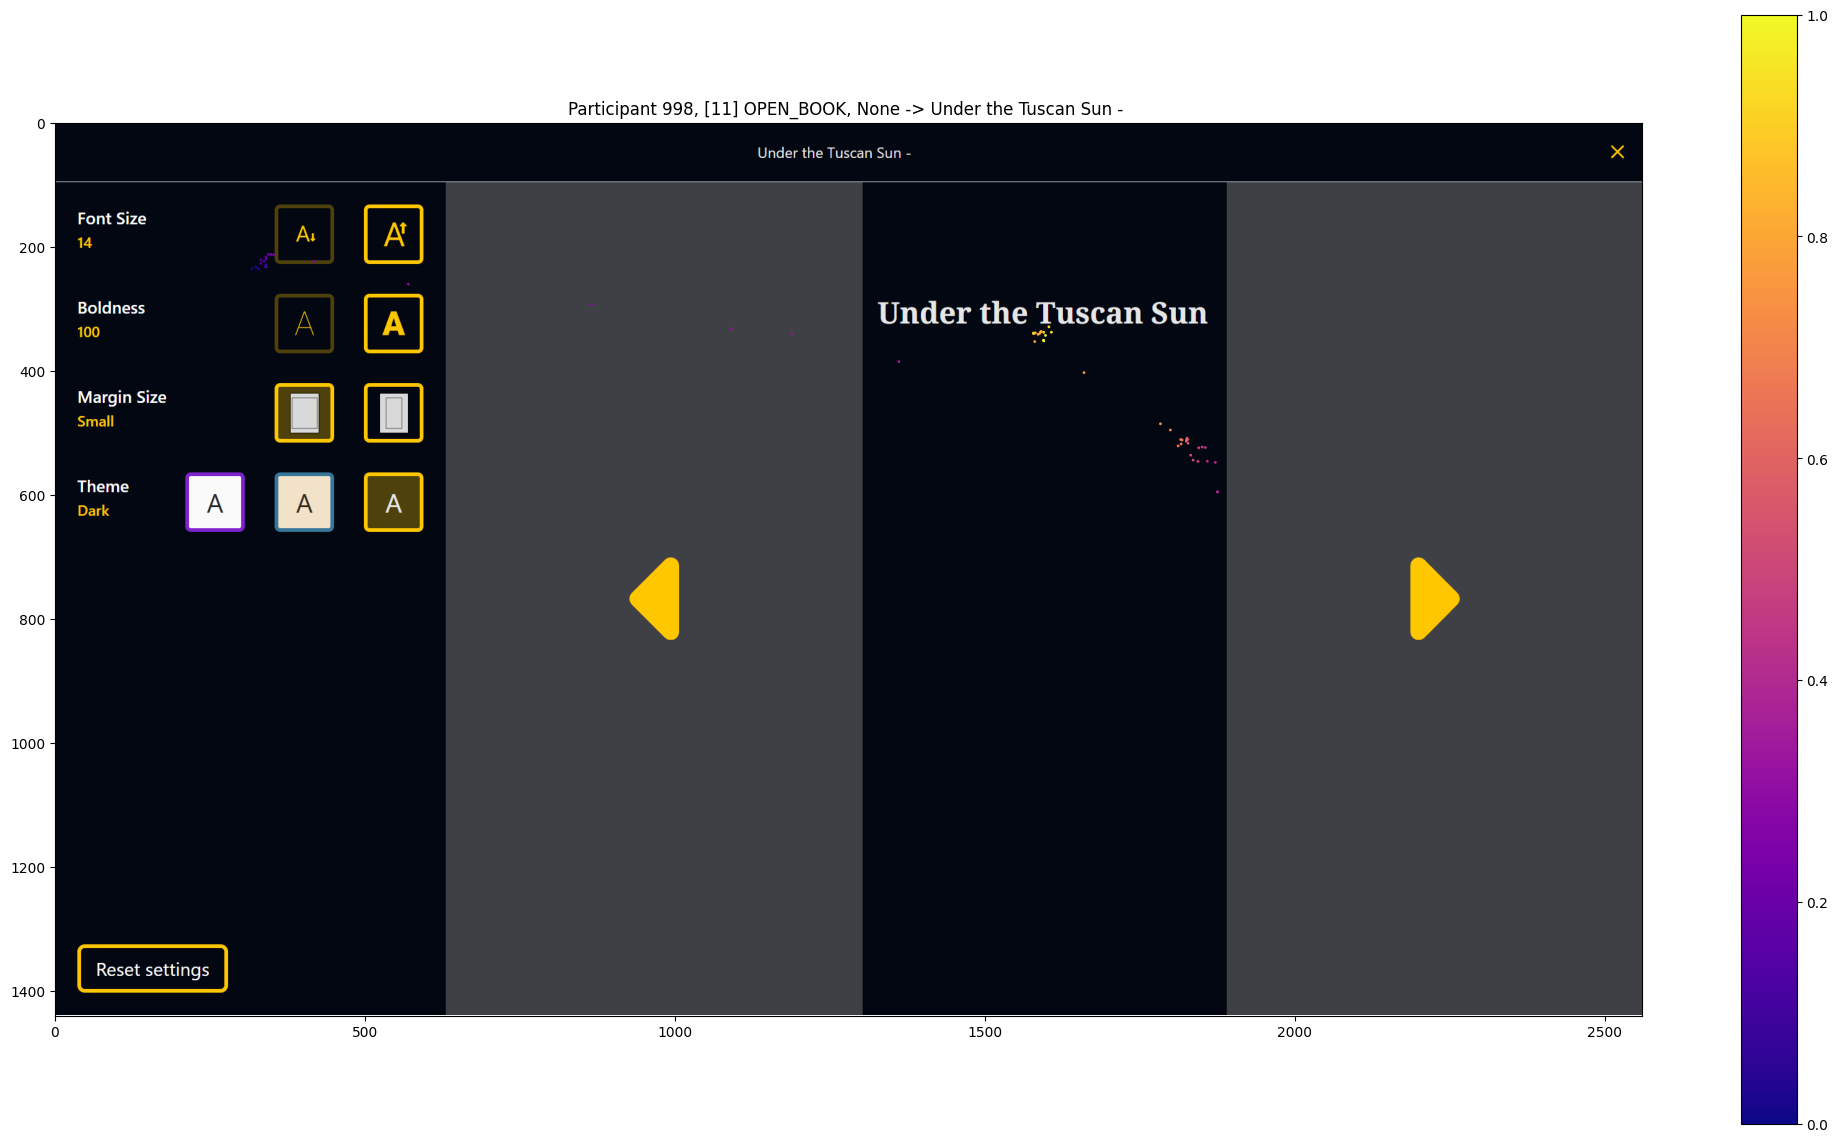

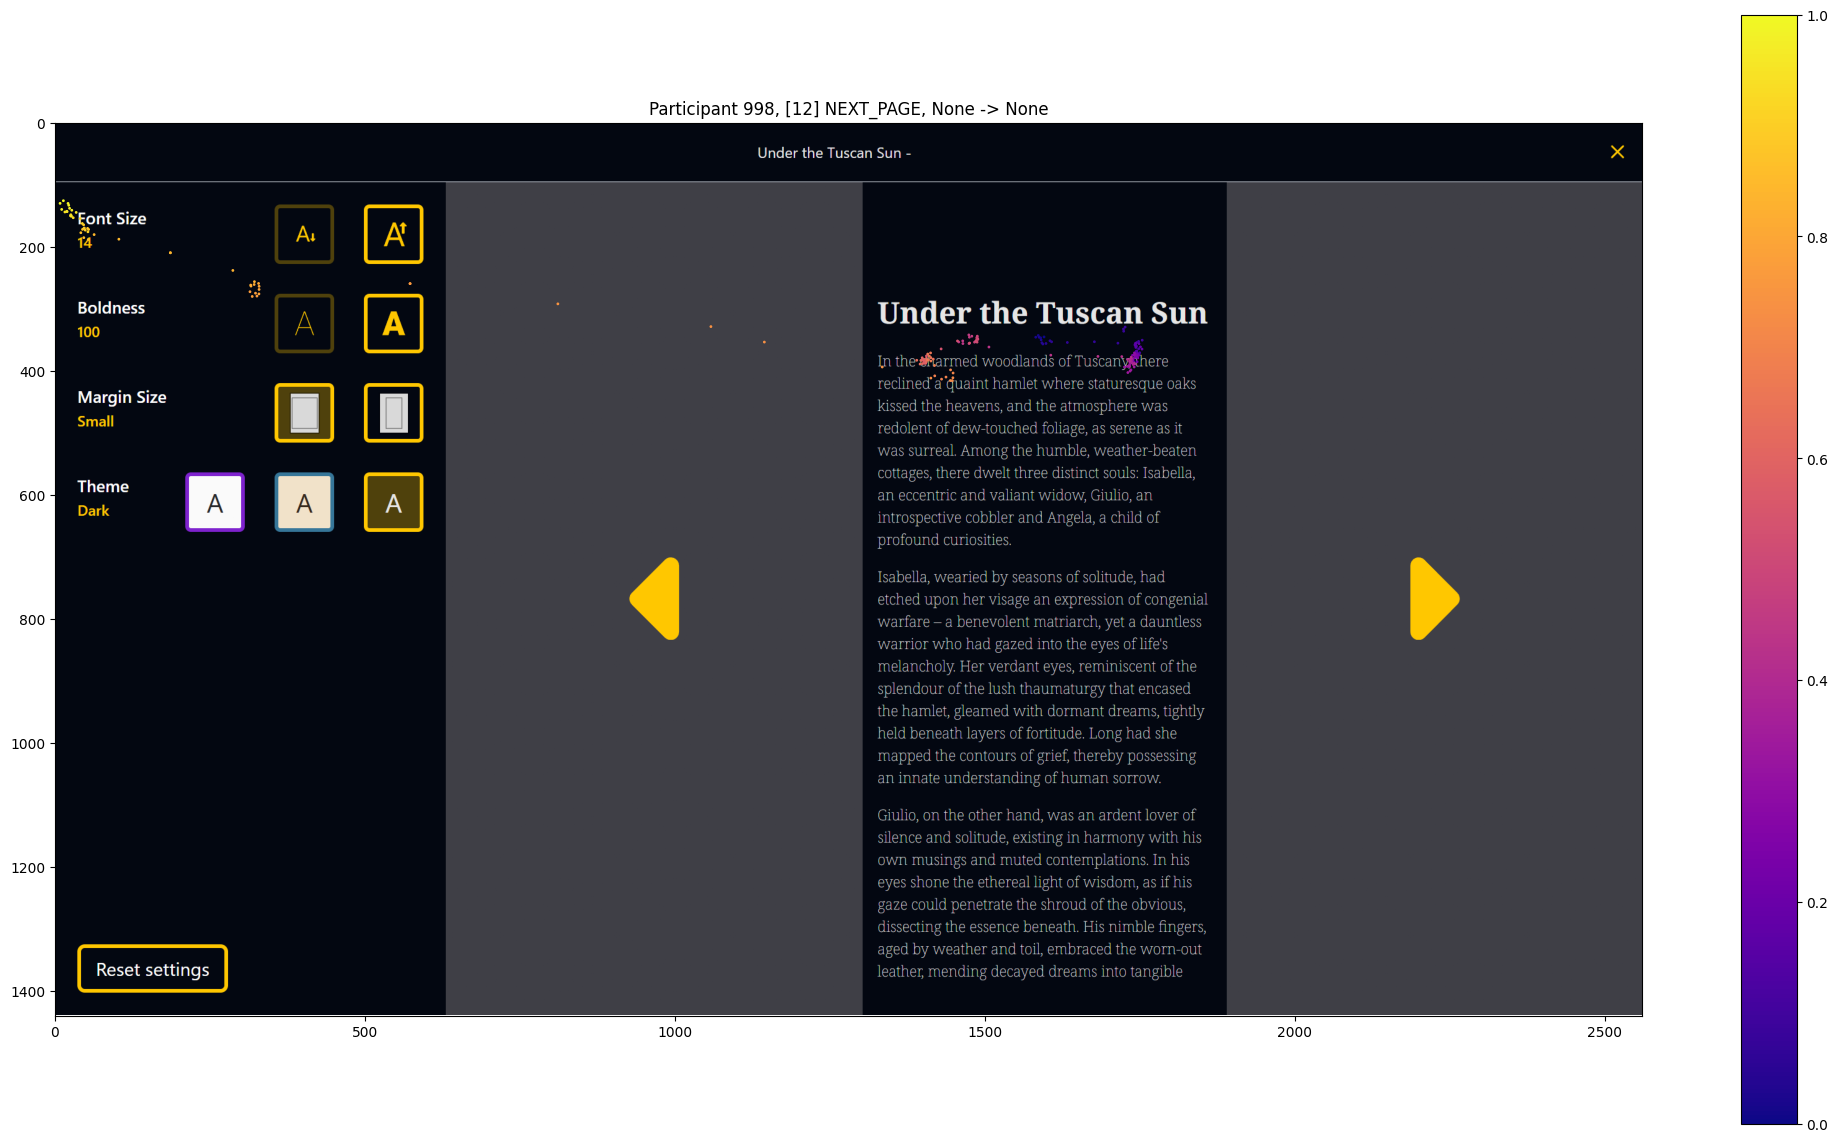

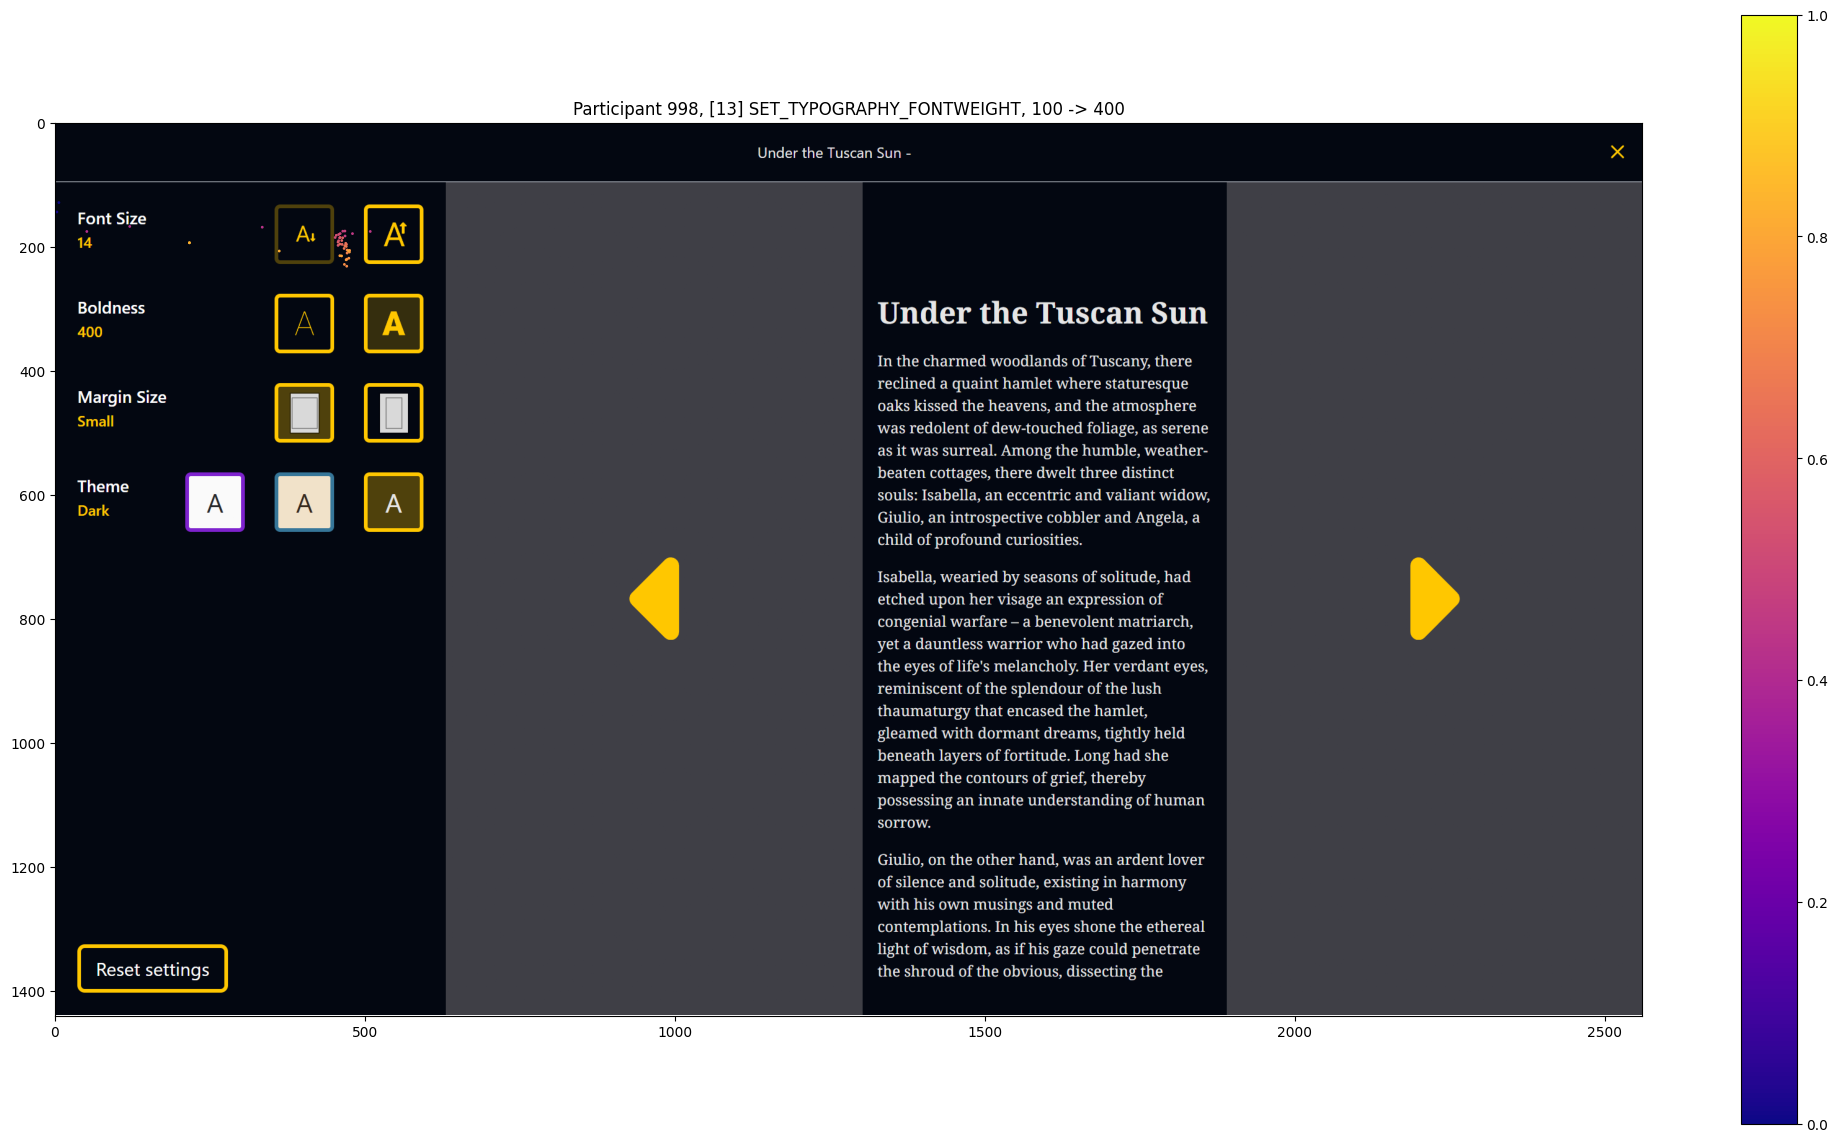

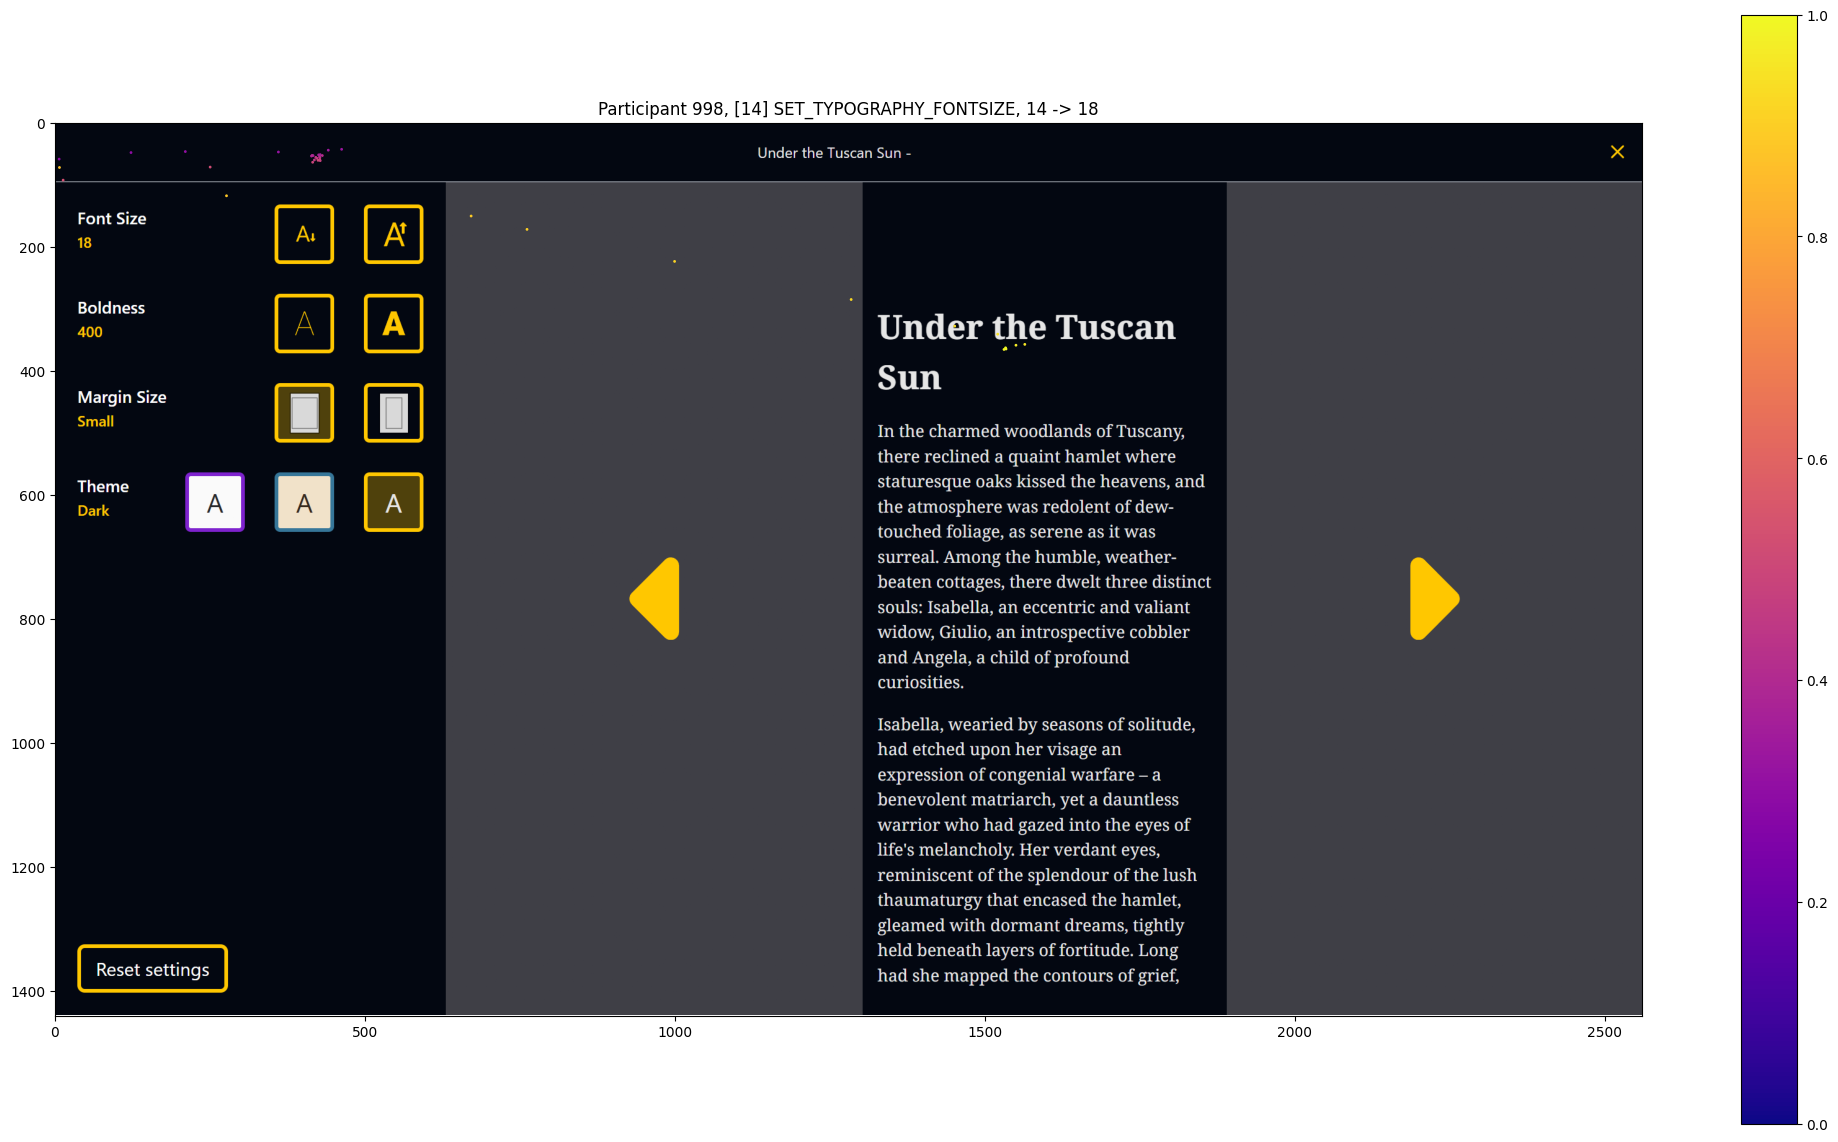

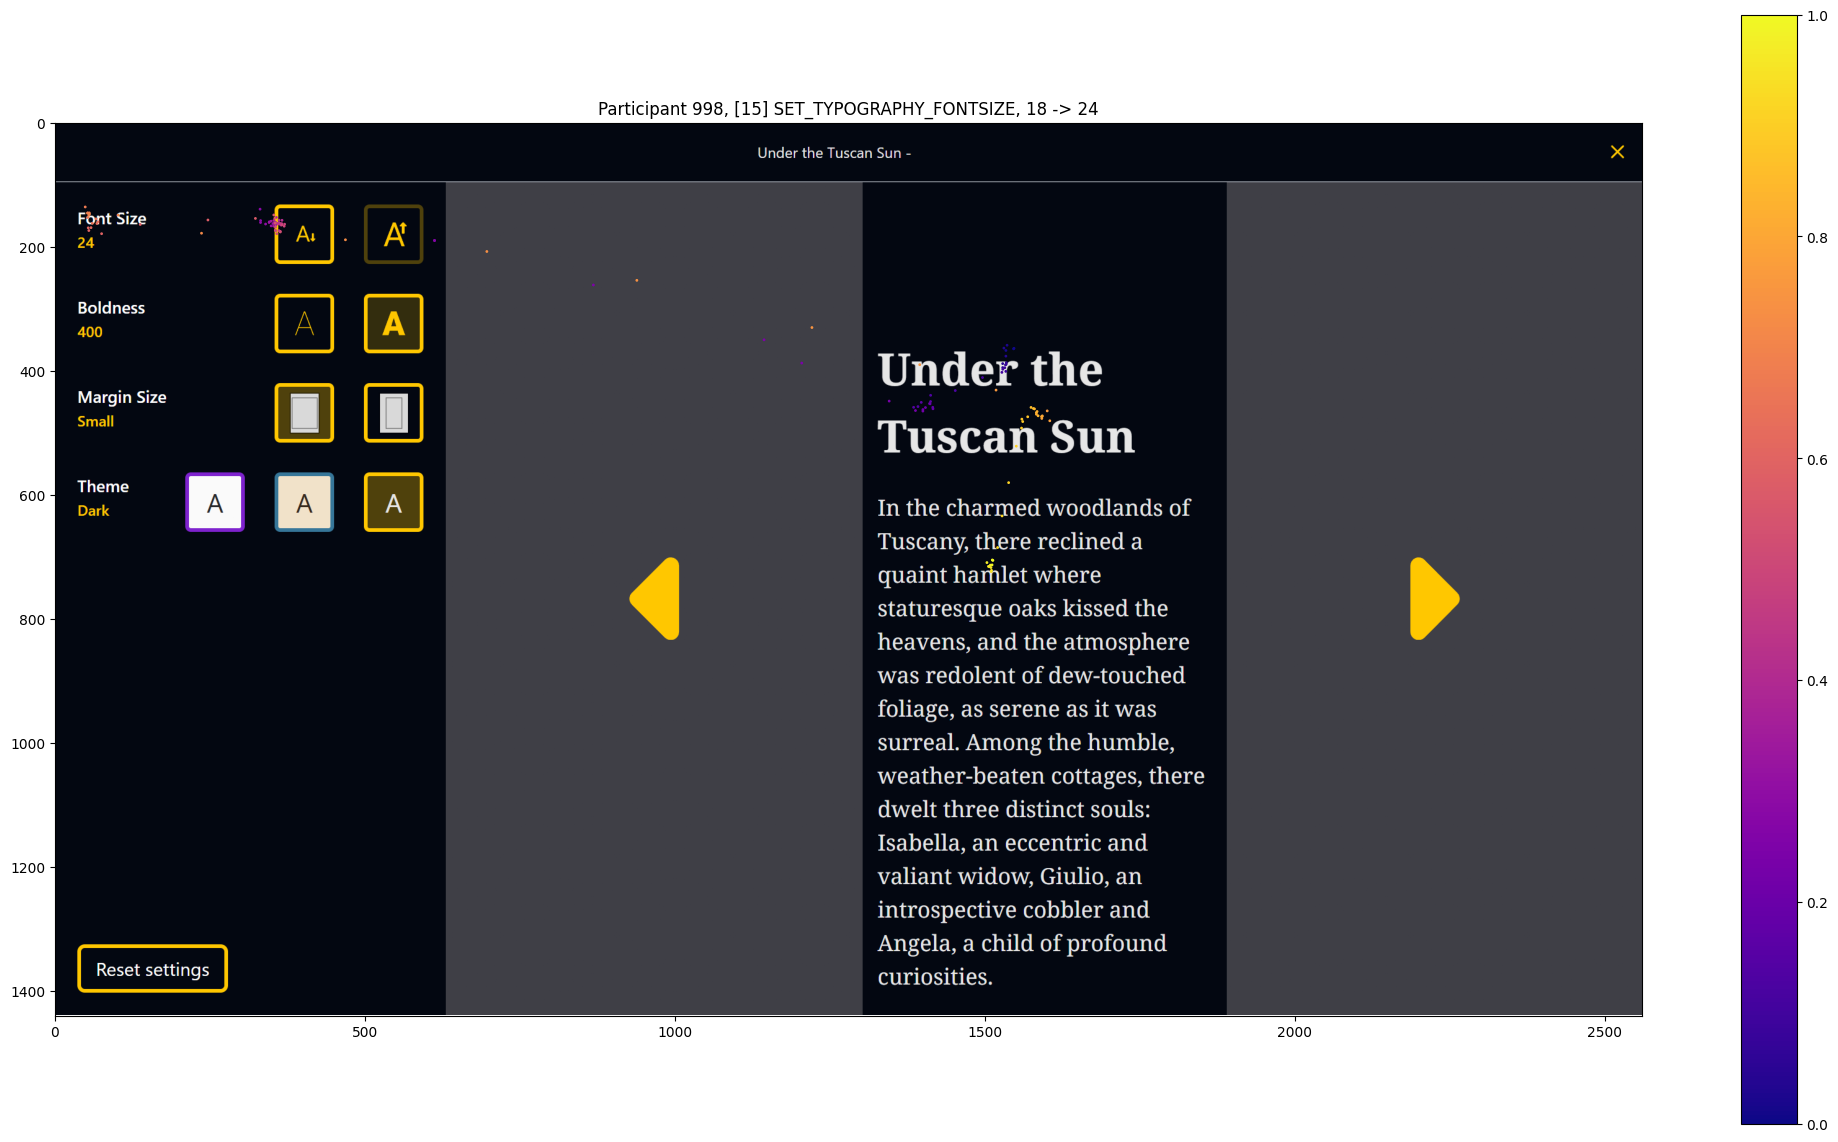

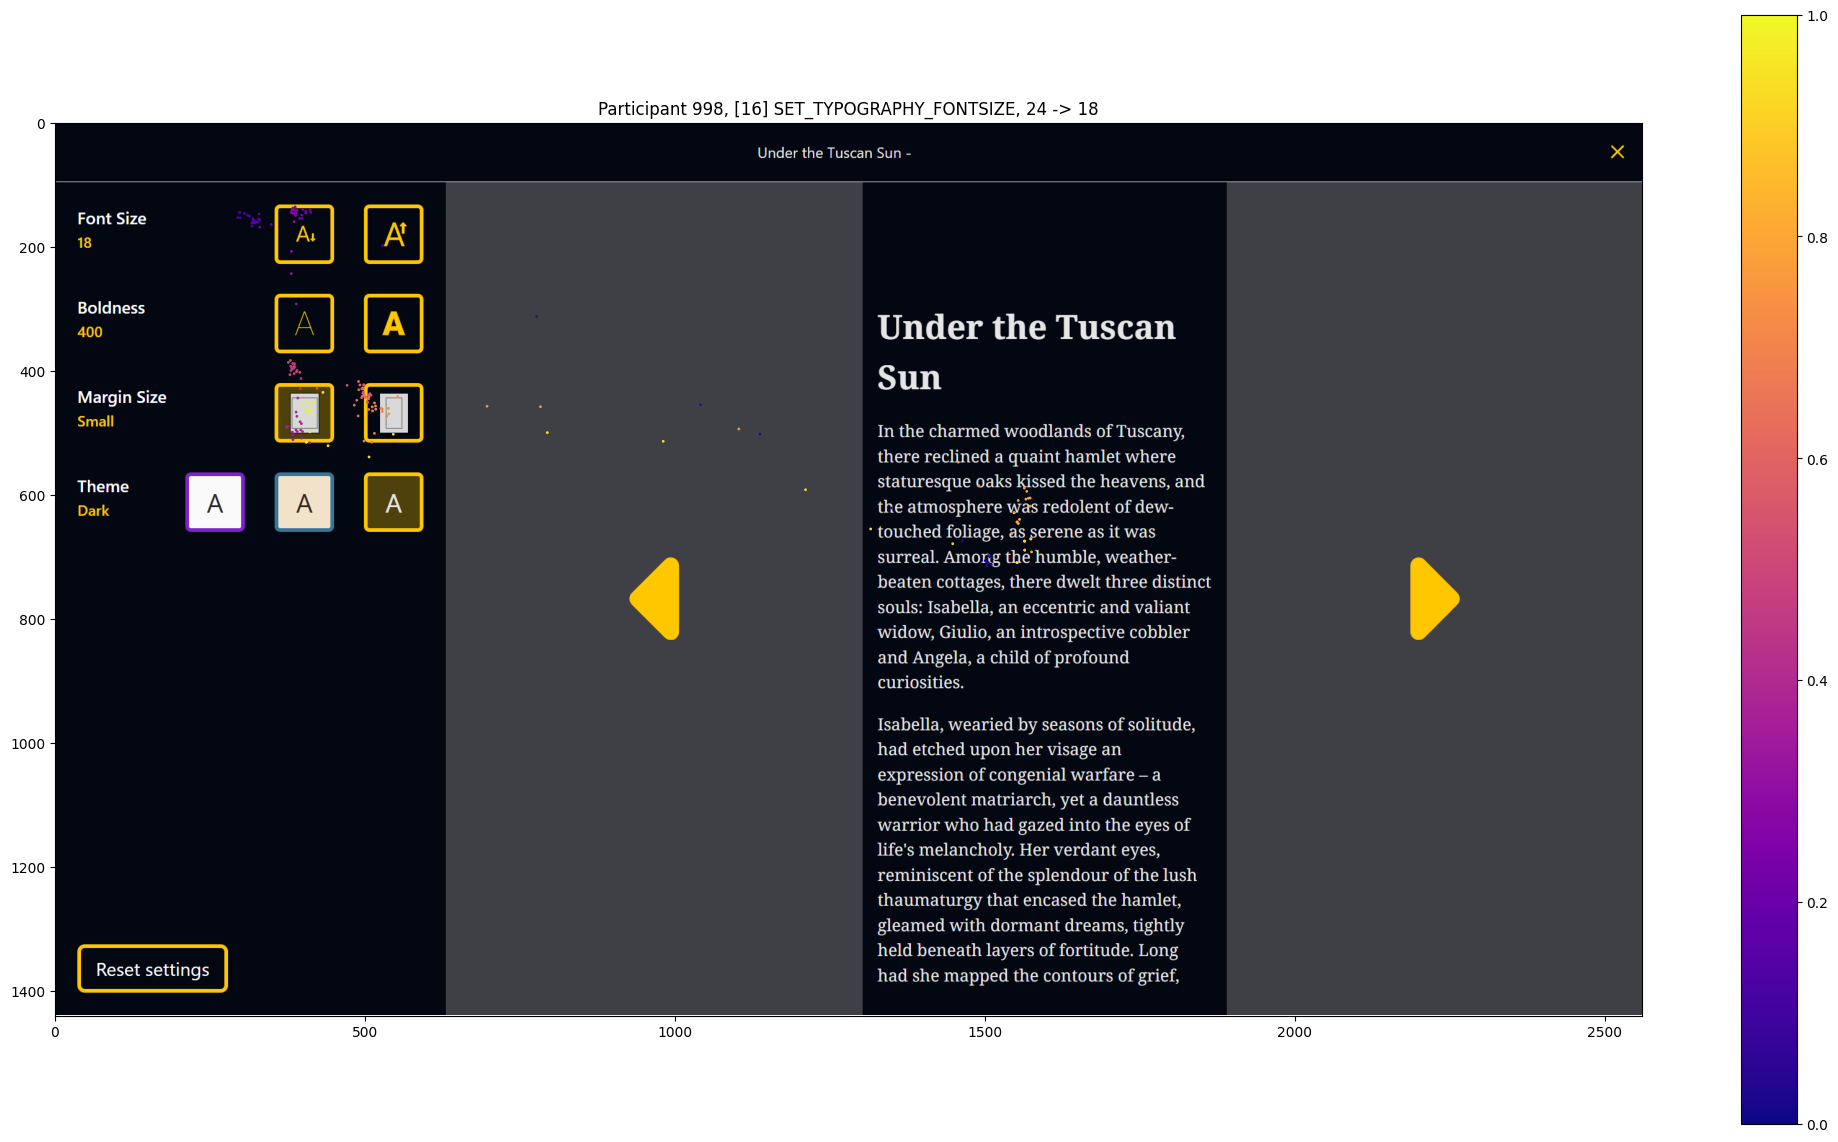

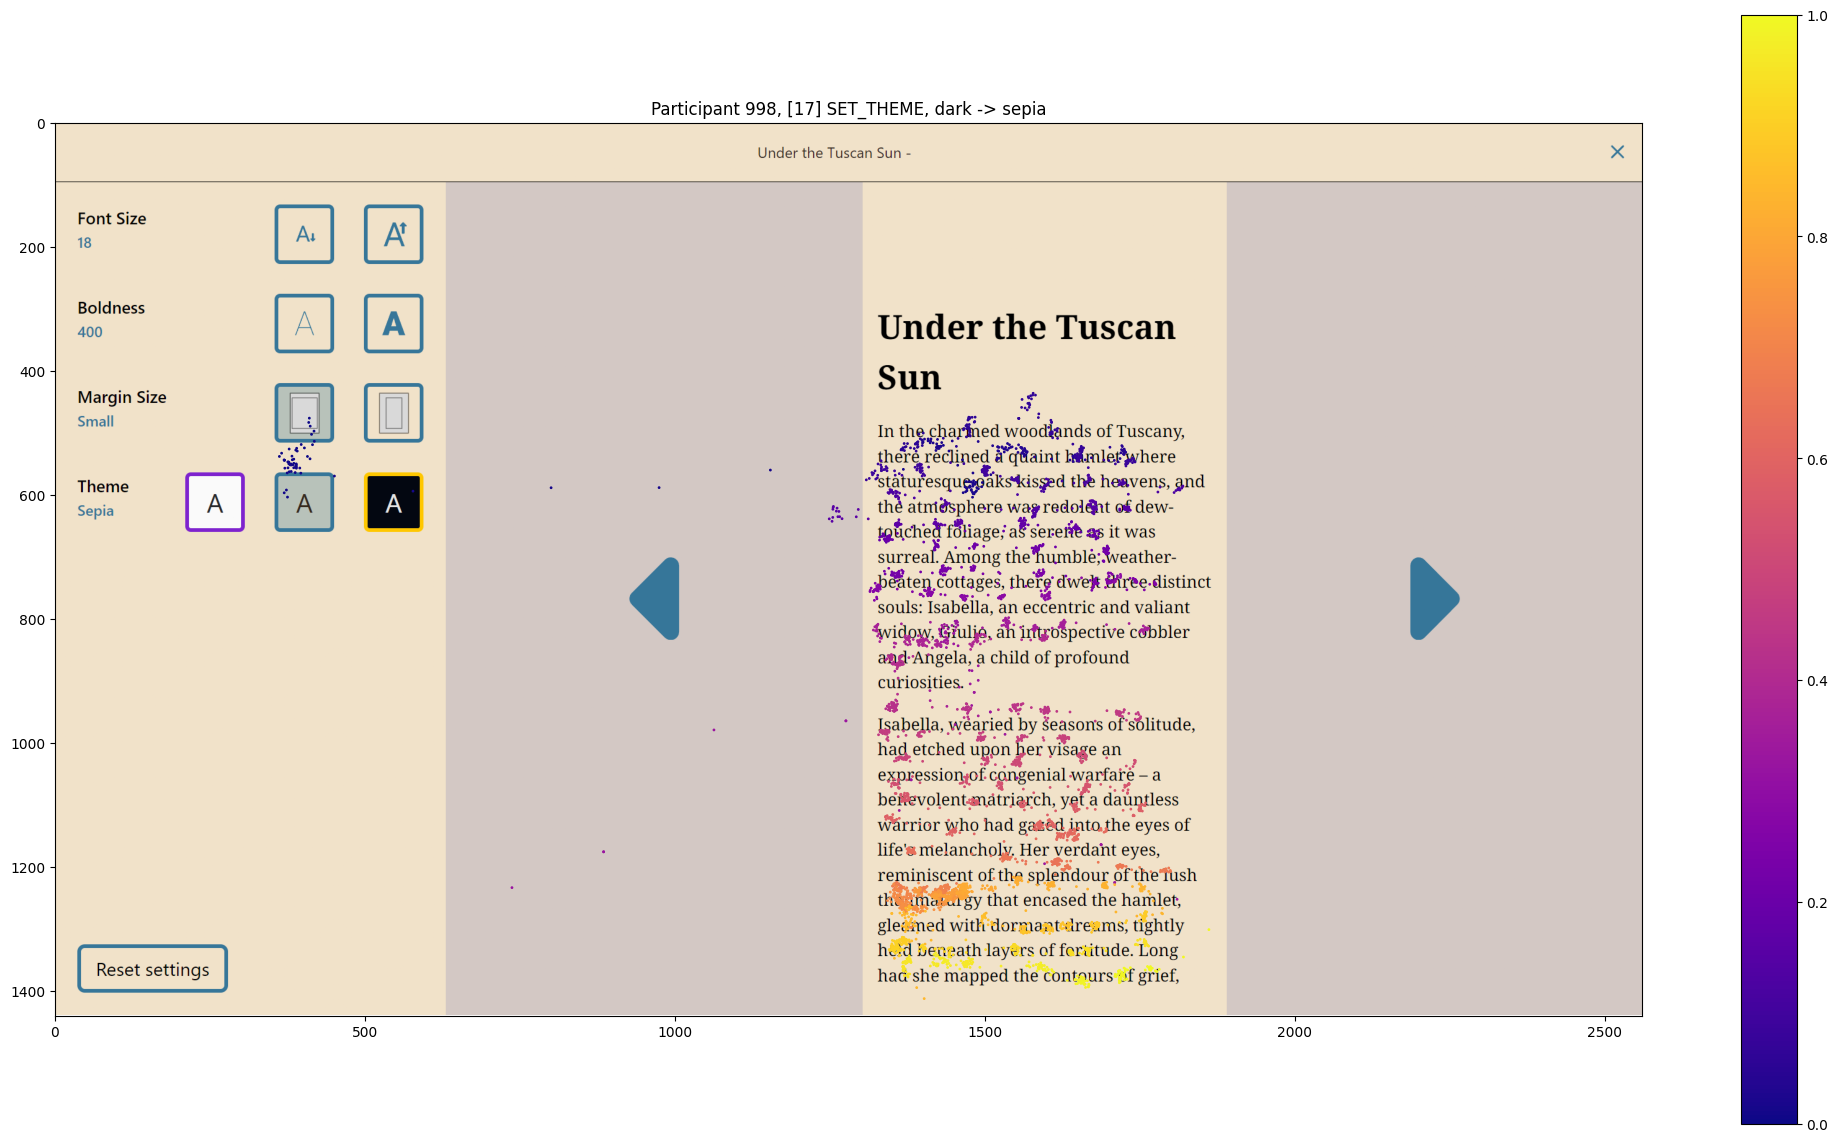

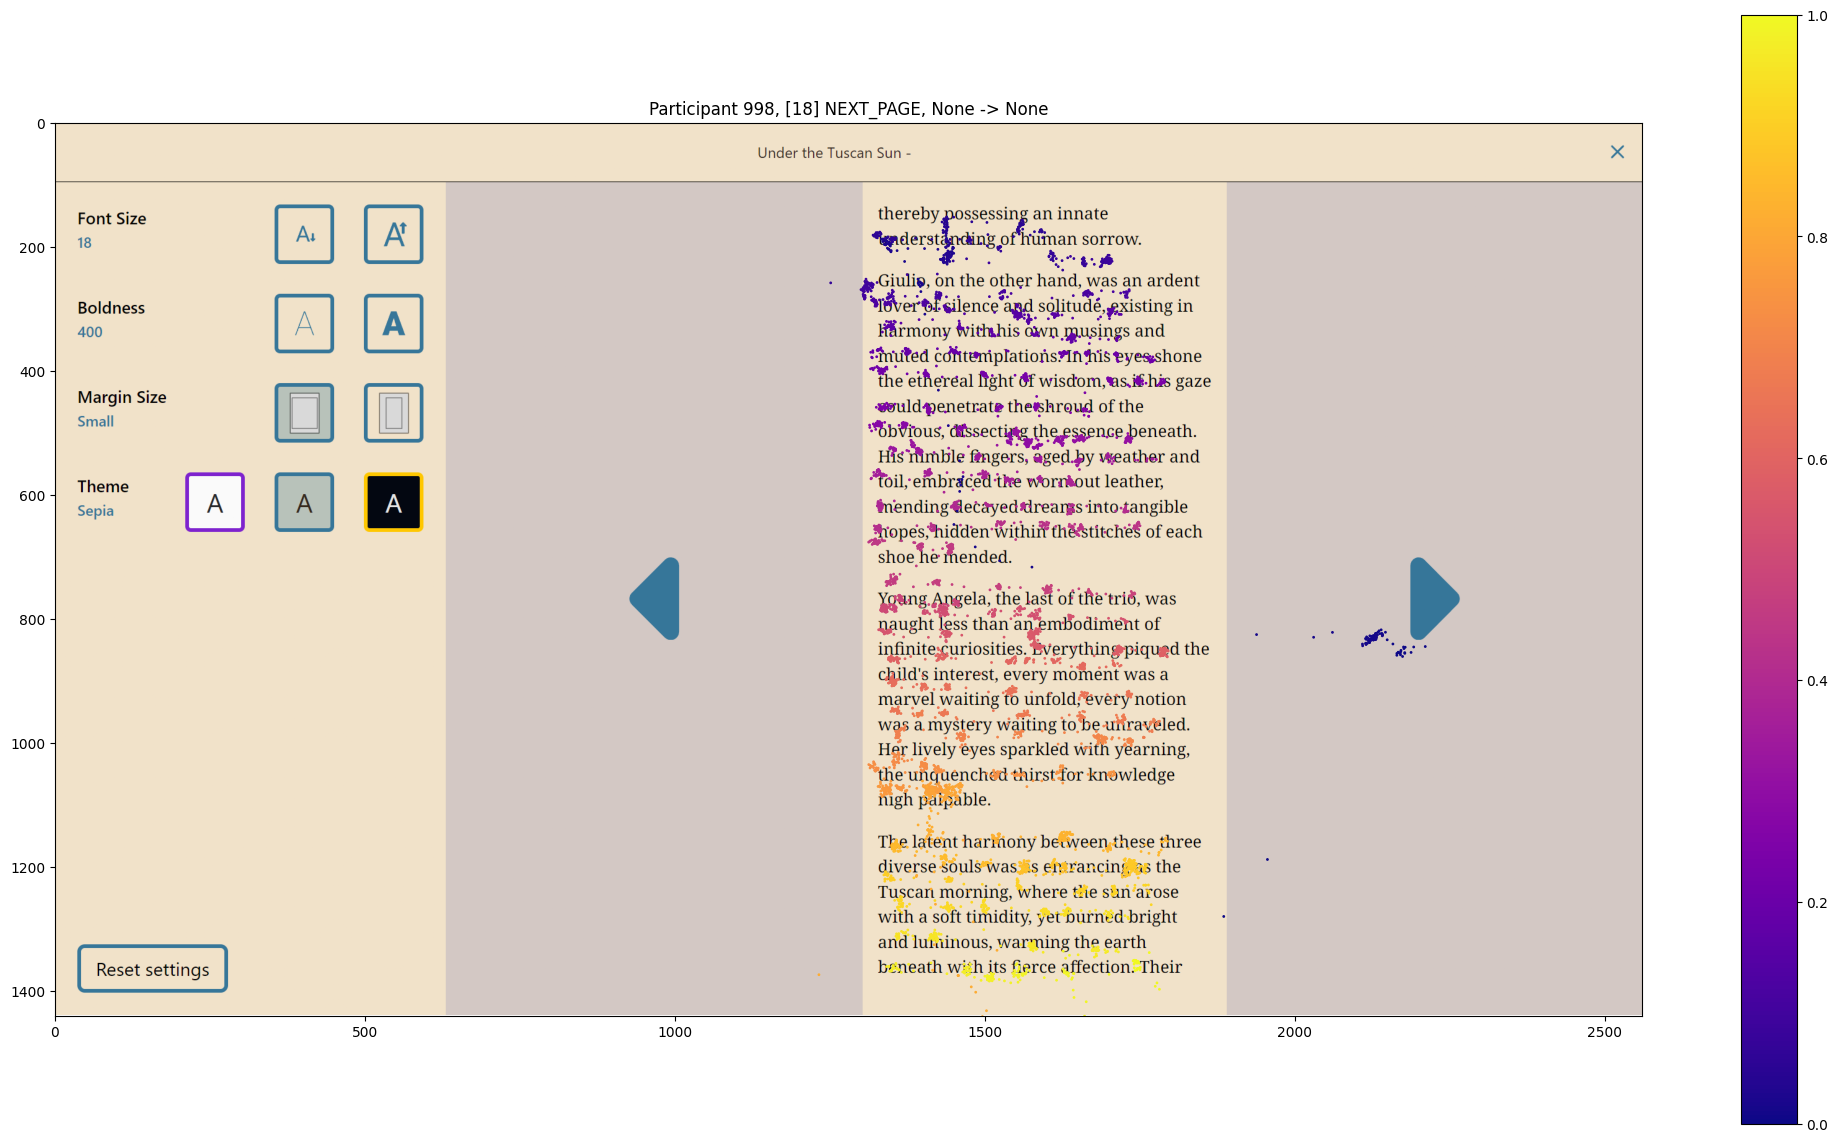

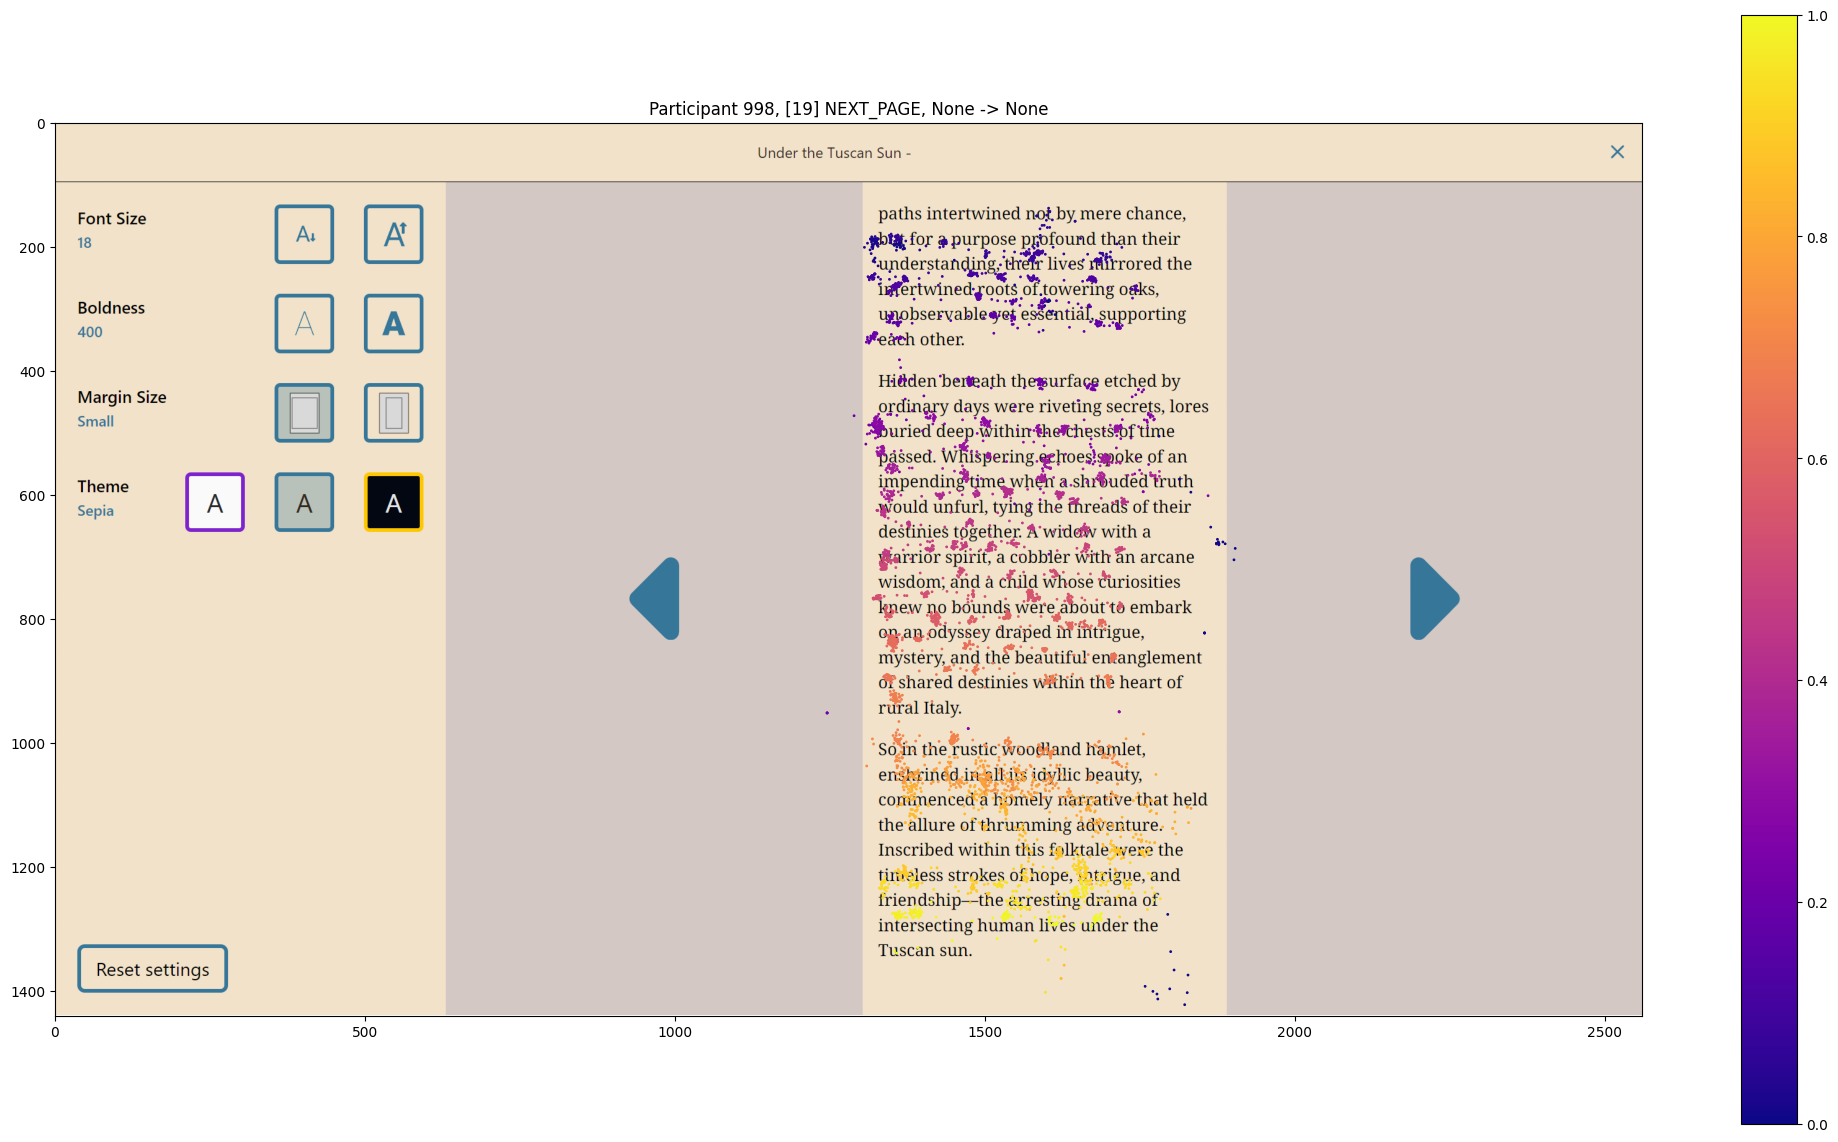

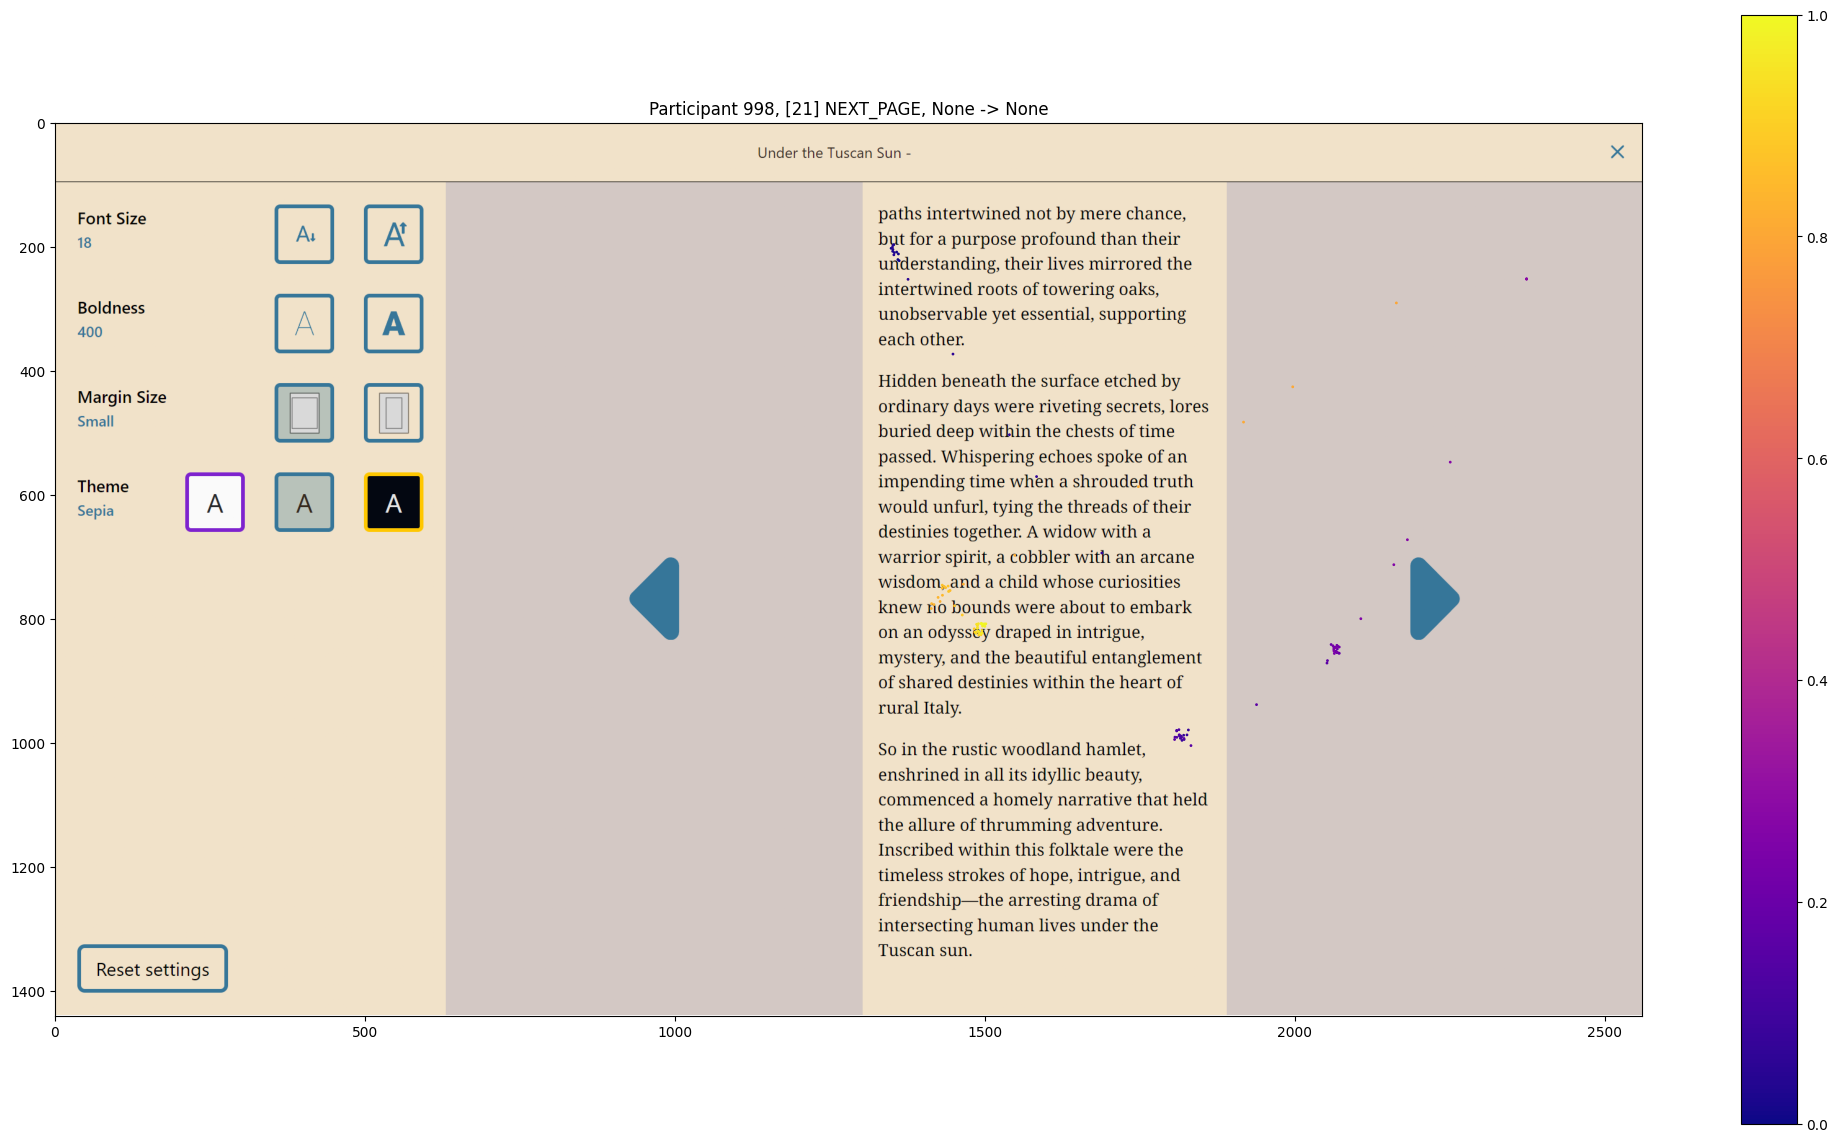

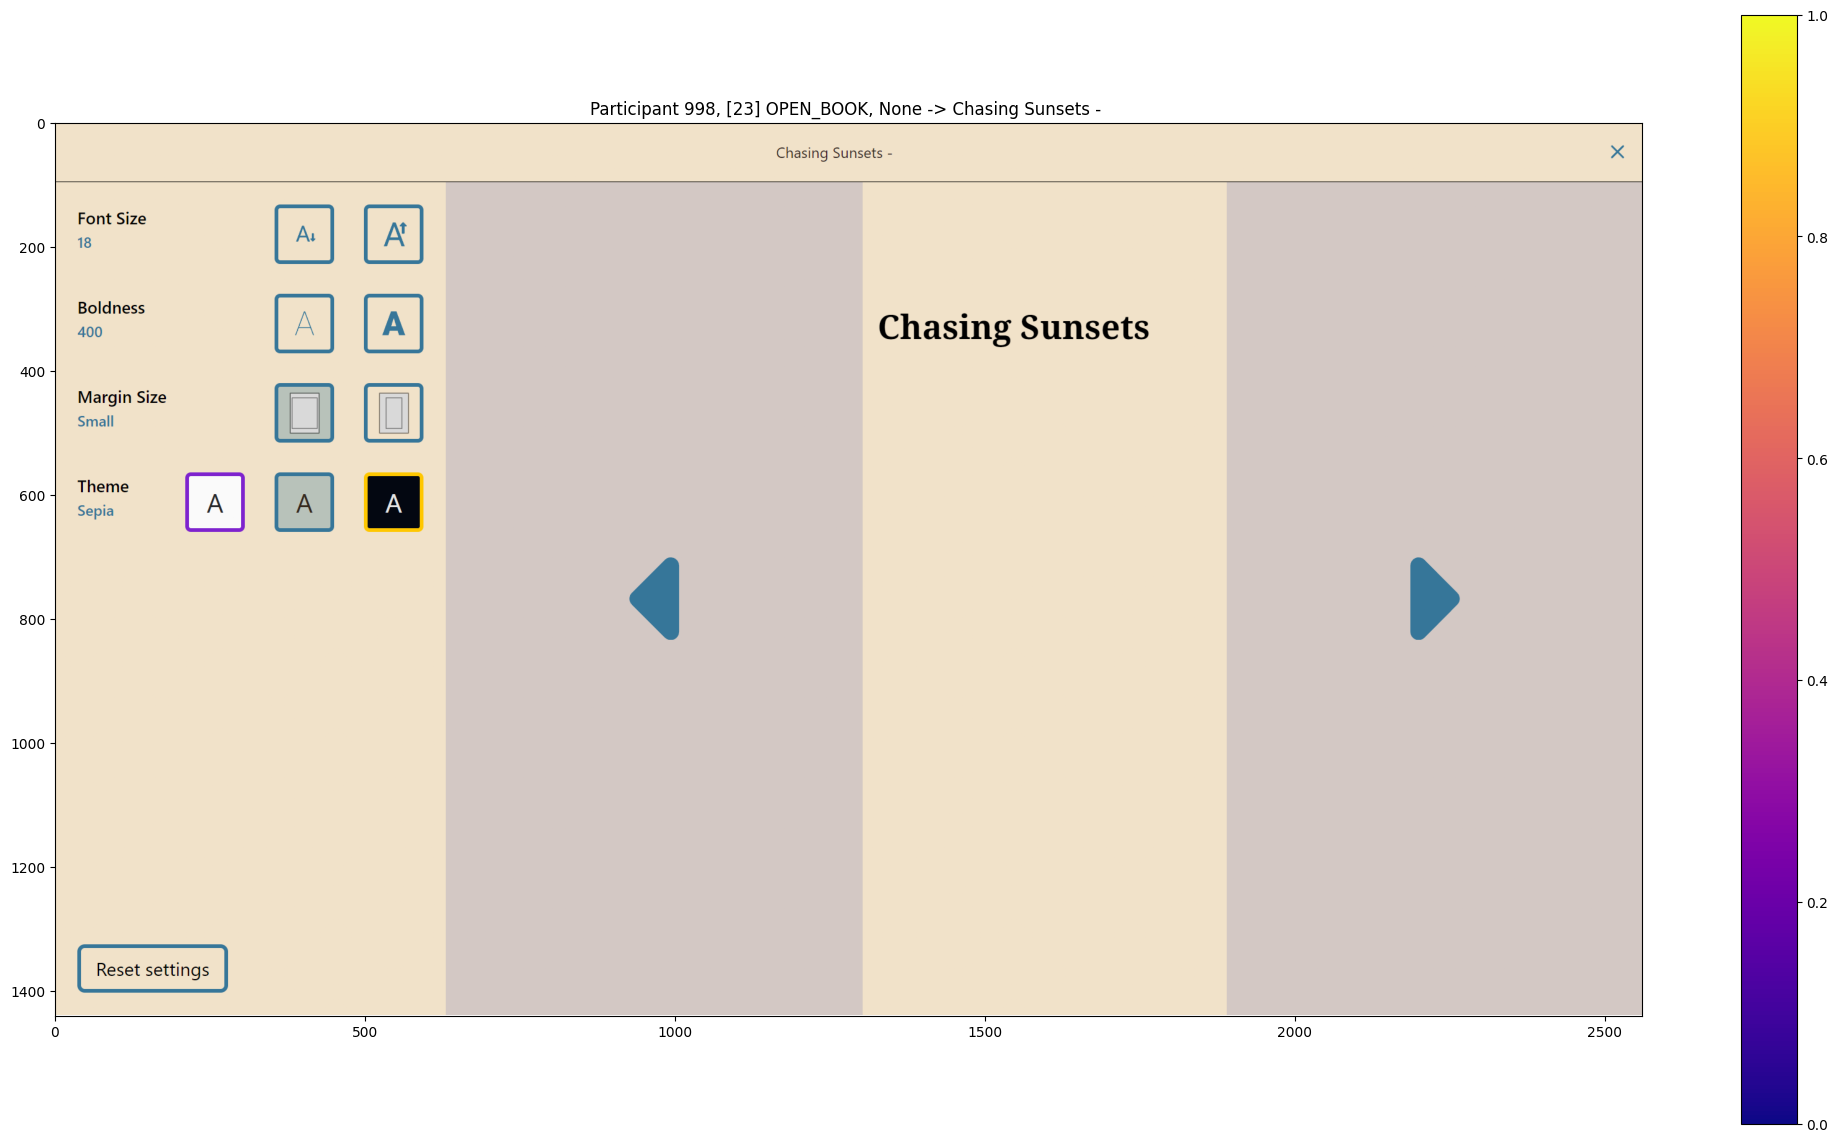

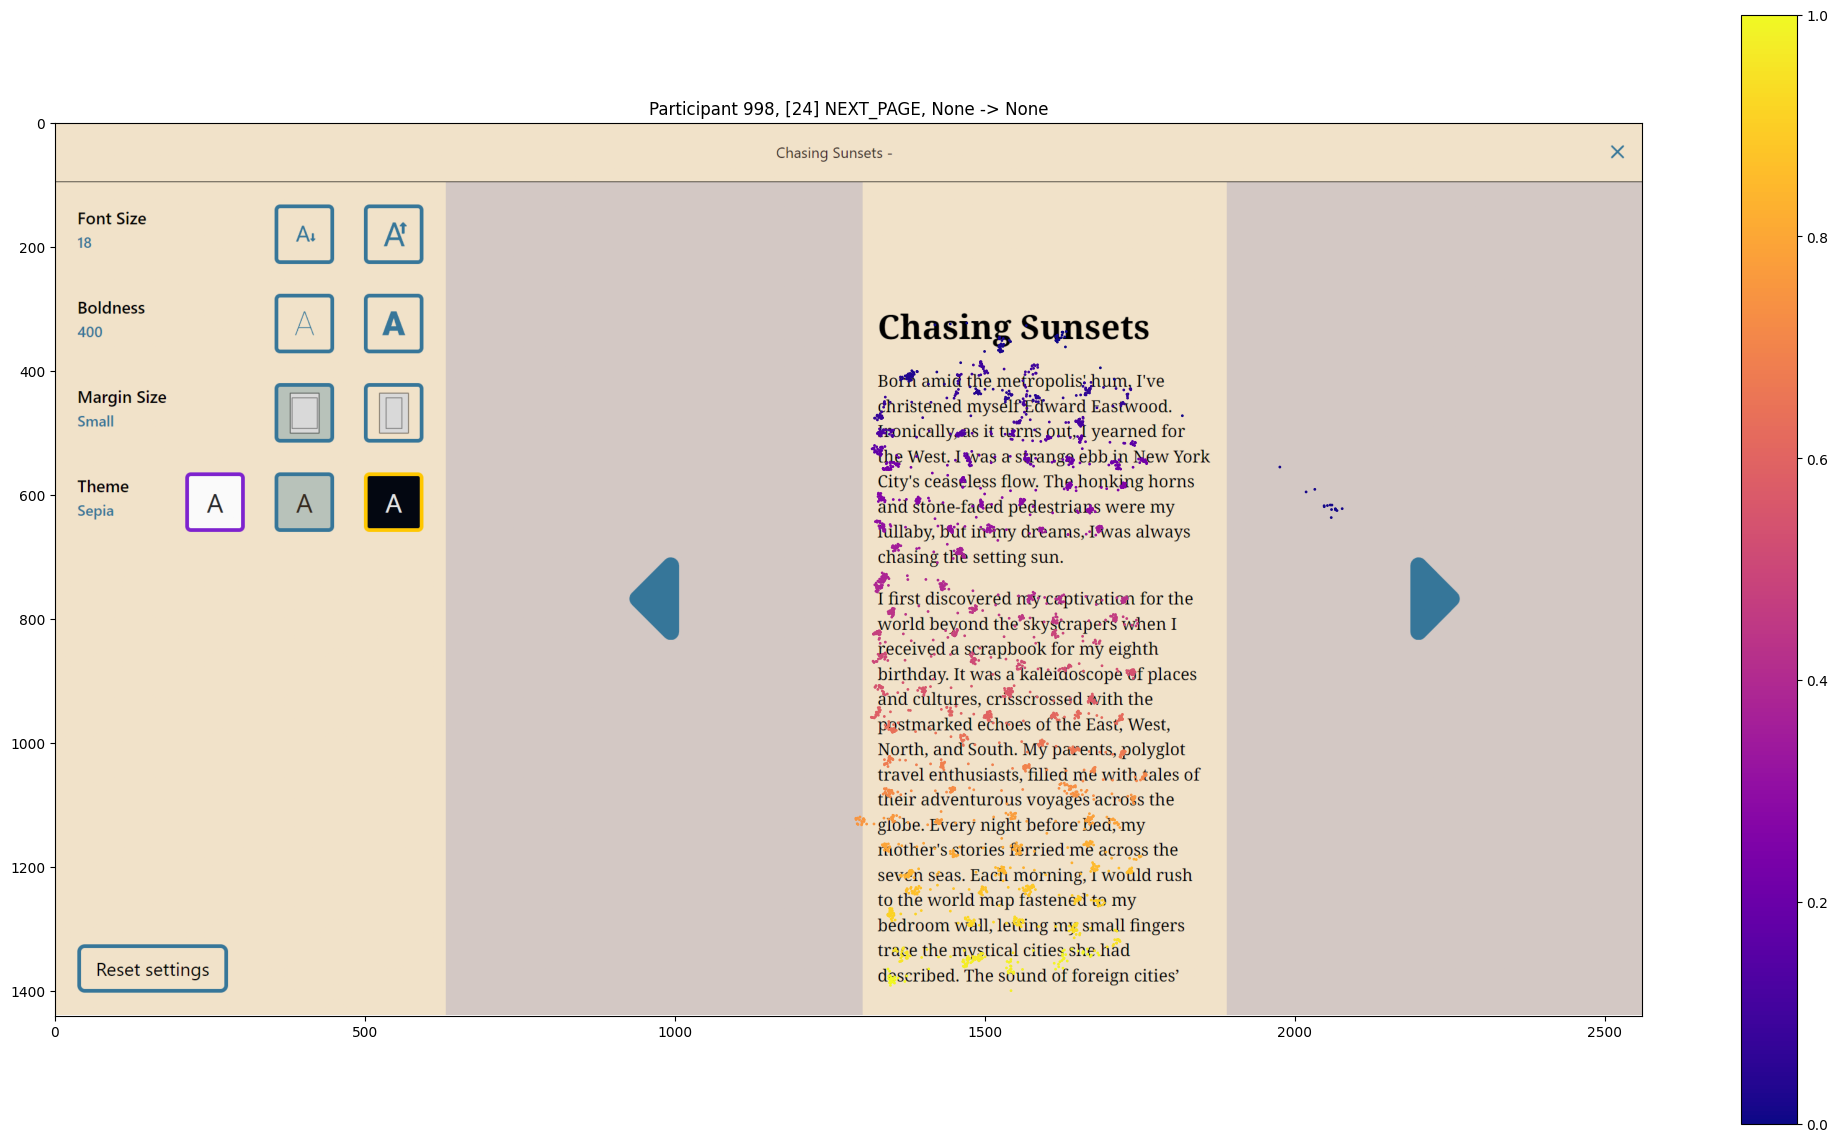

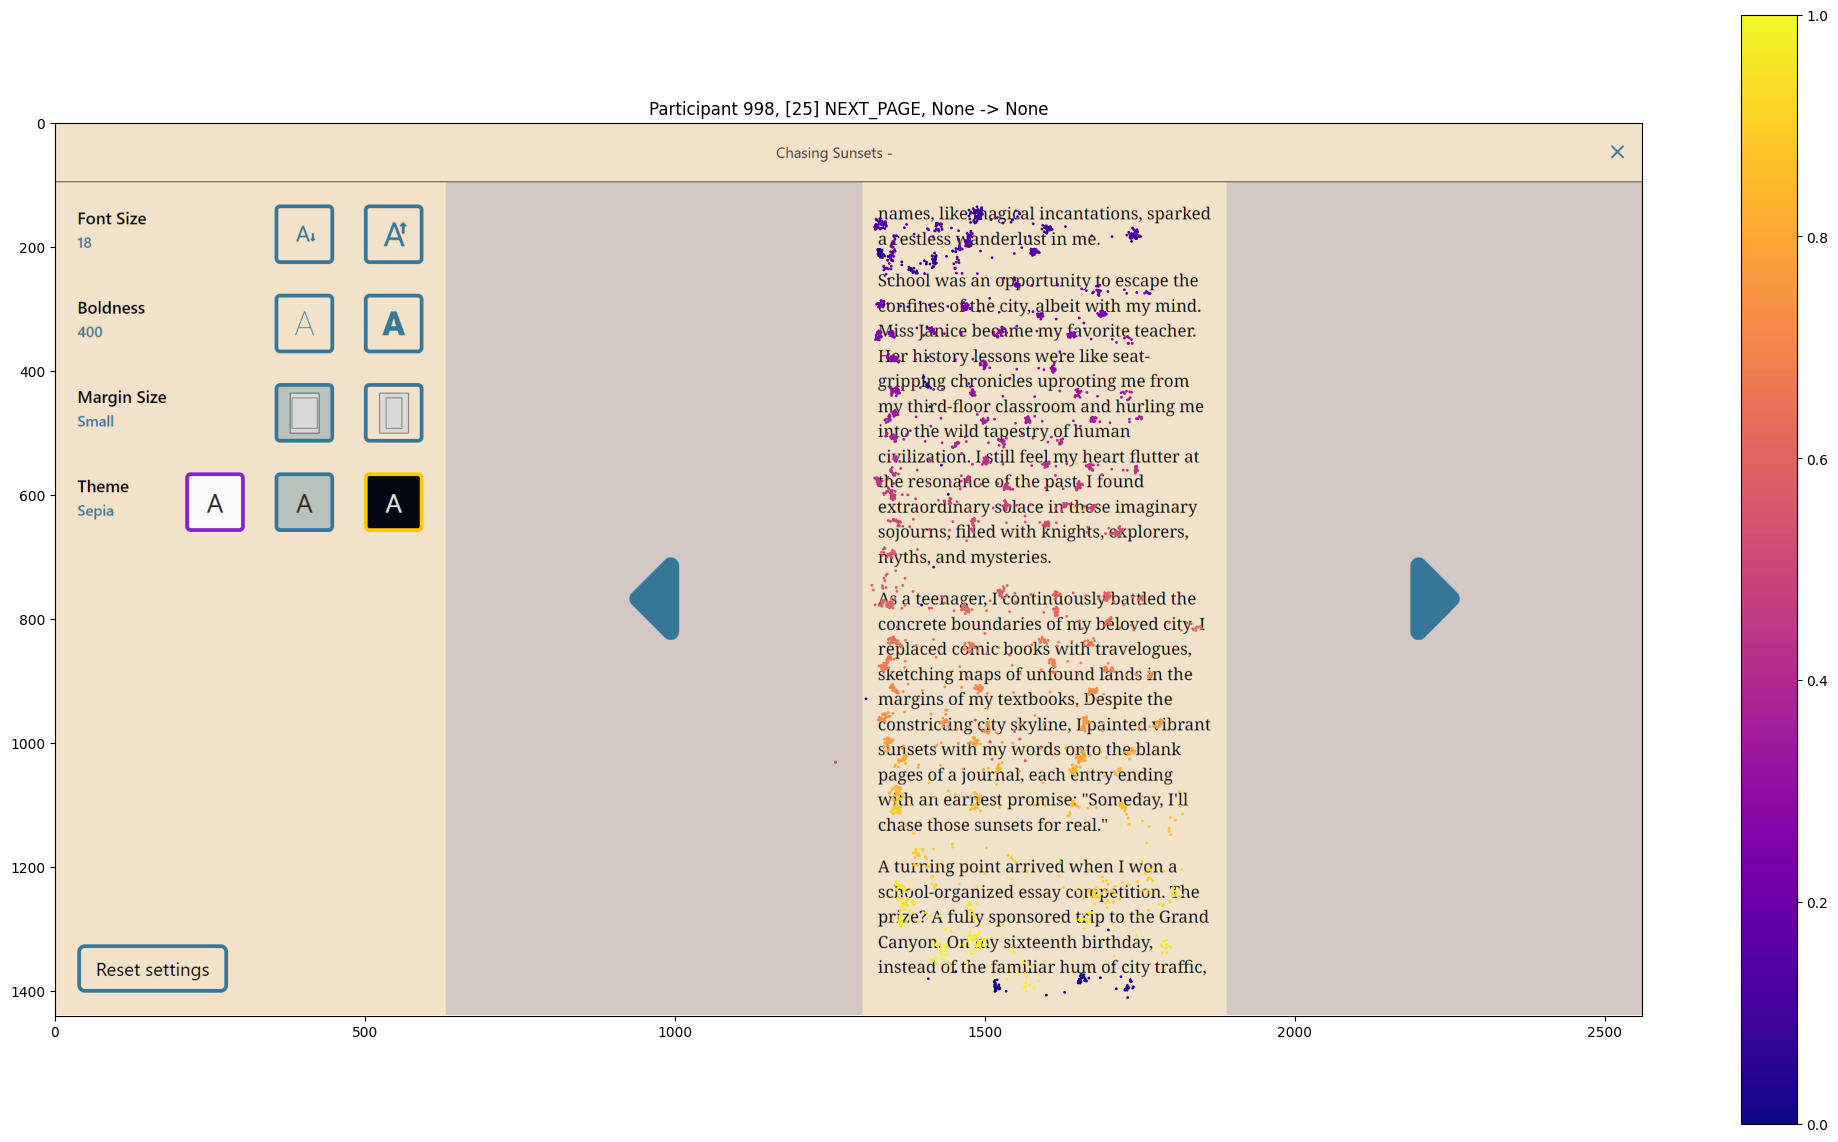

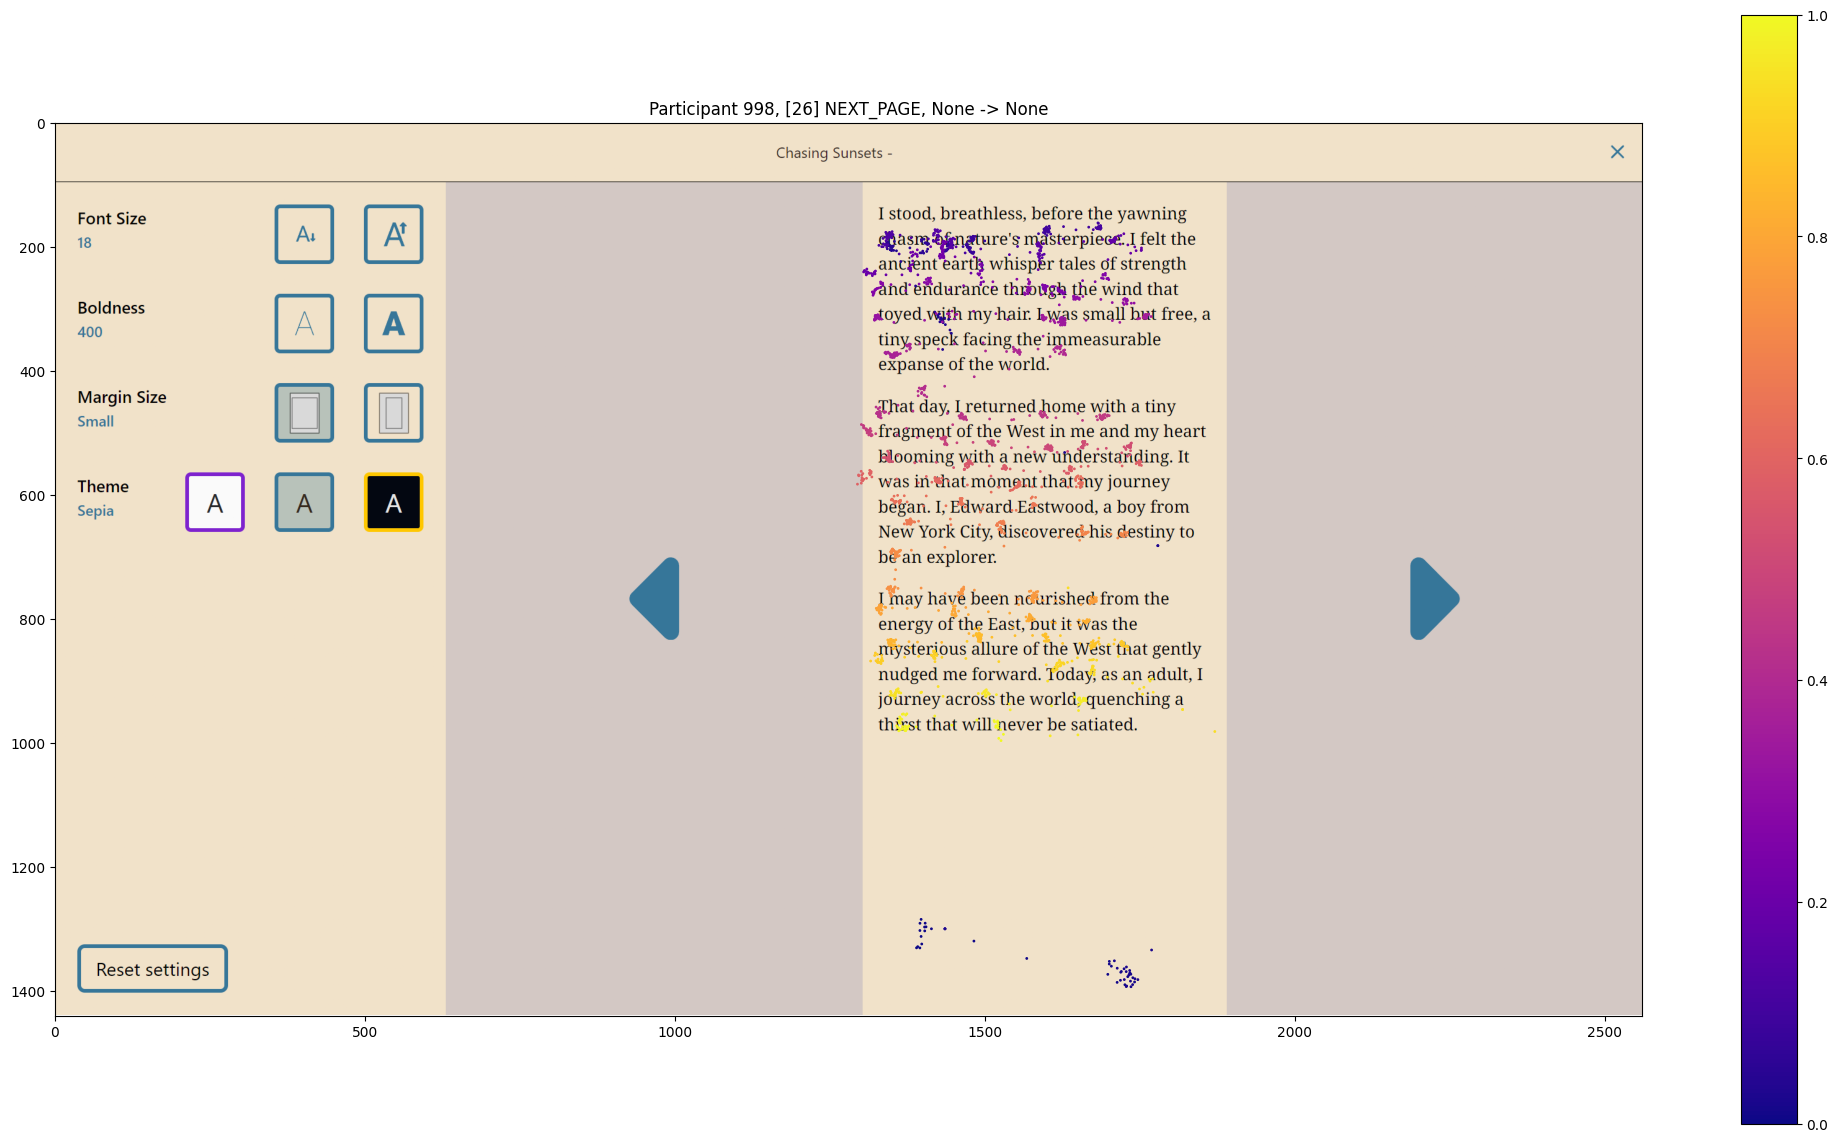

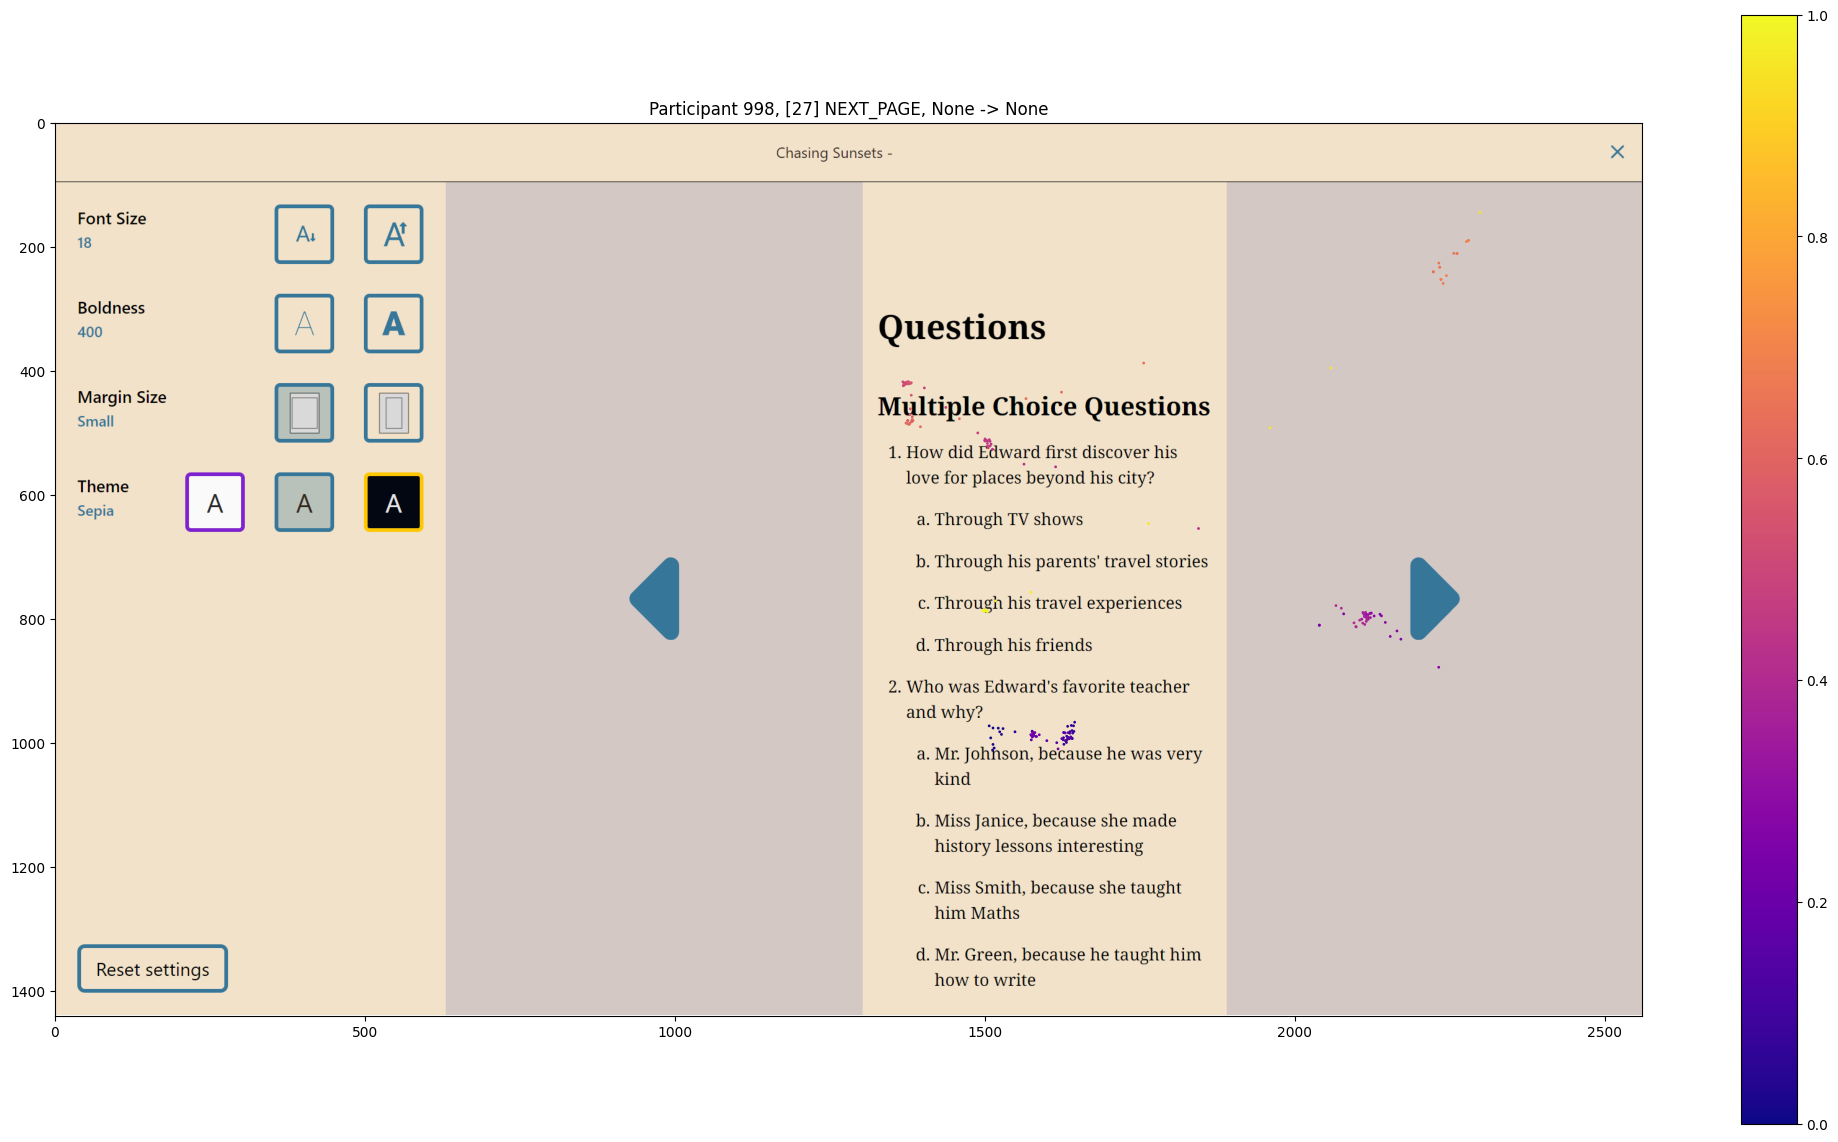

In [5]:
import os
from datetime import datetime

from utils import extract_gaze_data_between_timestamps_proper, plot_gaze_data_on_screenshot, print_record

# participants that were told that they can change the settings beforehand
participant_ids = [998]

# get the events 
for participant in participant_ids:
  events = Events.select().where(Events.participant_id==participant)
  
  current_json_file = None
  batches_of_events = {}
  current_batch = []
  for event in events:
    if event.event == "SELECT_TREATMENT":
      continue
    elif event.event == "CLOSE_BOOK":
      current_batch.append(event)
      batches_of_events[current_json_file] = current_batch
      current_batch = []
    elif event.event == "OPEN_BOOK":
      timestamp = event.time
      date = datetime.fromtimestamp(timestamp / 1000)
      date_string = date.strftime("%Y-%m-%d_%H-%M-%S")
      current_json_file = f"[{participant}]-{date_string}.json"
      current_batch.append(event)
    else:
      current_batch.append(event)

  # for each json file, get the gaze data
  for json_file, events in batches_of_events.items():
    # get the gaze data for this participant
    # the files are in eye_tracker_data/
    path = "eye_tracker_data/"

    # for start_event in events:
    gaze_data_filename = json_file
    gaze_data_filepath = os.path.join(path, gaze_data_filename)
    # Read the file
    import json
    with open(gaze_data_filepath, "r") as f:
      gaze_data = json.load(f)

    pairs = list(zip(events, events[1:]))
    for begin_page_event, end_page_event in pairs:
      T_start = begin_page_event.time
      T_end = end_page_event.time

      # ignore the event if the participant only looked at this page for less than 5 seconds
      if T_end - T_start < 1_000:
        continue

      gaze_data_between_pageturn_events = extract_gaze_data_between_timestamps_proper(gaze_data, T_start, T_end)
      
      screenshot_path = begin_page_event.screenshot_file
      print_record(begin_page_event)
      plot_gaze_data_on_screenshot(gaze_data_between_pageturn_events, screenshot_path, title=f"Participant {participant}, [{begin_page_event.id}] {begin_page_event.event}, {begin_page_event.old_value} -> {begin_page_event.new_value}")
   


In [6]:
from utils import show_participant_screenshots


events = Events.select().where(Events.participant_id==999)
# show_participant_screenshots(events)